**Chapter 17 – Autoencoders and GANs**

_This notebook contains all the sample code in chapter 17._

<table align="left">
  <td>
    <a target="_blank" href=
    "https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save
the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated, so
we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

A couple utility functions to plot grayscale 28x28 image:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# PCA with a linear Autoencoder

Build 3D dataset:

In [3]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

Now let's build the Autoencoder...

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1.5))

In [5]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 0s 976us/step - loss: 0.2547
Epoch 2/20
2/2 [==============================] - 0s 847us/step - loss: 0.1032
Epoch 3/20
2/2 [==============================] - 0s 800us/step - loss: 0.0551
Epoch 4/20
2/2 [==============================] - 0s 726us/step - loss: 0.0503
Epoch 5/20
2/2 [==============================] - 0s 902us/step - loss: 0.0839
Epoch 6/20
2/2 [==============================] - 0s 913us/step - loss: 0.2223
Epoch 7/20
2/2 [==============================] - 0s 794us/step - loss: 0.0913
Epoch 8/20
2/2 [==============================] - 0s 781us/ste

In [6]:
codings = encoder.predict(X_train)
codings

array([[-1.4355531 ,  0.0428833 ],
       [ 0.25562766,  0.30128664],
       [-1.318222  ,  0.0658702 ],
       [-0.88929975,  0.6619917 ],
       [-0.82498777,  0.6101461 ],
       [ 1.0578616 , -0.52134335],
       [-1.5449699 ,  0.05390465],
       [ 0.30422837, -0.80631614],
       [ 1.0506716 , -0.23402454],
       [ 0.78620046,  0.07545841],
       [-1.056118  ,  0.4912582 ],
       [ 1.1134901 , -0.69831294],
       [-1.2449077 ,  0.28120393],
       [-1.3697135 ,  0.09860048],
       [ 0.99625945, -0.73822534],
       [-0.18016781,  0.45273274],
       [ 0.33600962, -0.8470403 ],
       [ 0.9294085 ,  0.00763285],
       [ 0.57810086, -0.8832273 ],
       [-1.3940148 ,  0.05333473],
       [ 0.7075019 ,  0.1724893 ],
       [-1.3497142 , -0.17086206],
       [-1.0206423 ,  0.44099715],
       [-1.3840227 ,  0.31660947],
       [ 1.0085891 , -0.70621395],
       [ 0.6046581 , -0.87926406],
       [-0.05950198,  0.51454484],
       [ 1.002238  , -0.6671876 ],
       [-0.9221157 ,

Saving figure linear_autoencoder_pca_plot


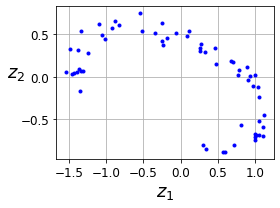

In [7]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

# Stacked Autoencoders

Let's use MNIST:

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

## Train all layers at once

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [9]:
def rounded_accuracy(y_true, y_pred):
    print("y_true: ", y_true)

    print(y_pred)
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [10]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5),
                   metrics=[rounded_accuracy])

history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
y_true:  Tensor("IteratorGetNext:1", shape=(None, 28, 28), dtype=float32)
Tensor("sequential_5/sequential_4/reshape/Reshape:0", shape=(None, 28, 28), dtype=float32)
y_true:  Tensor("IteratorGetNext:1", shape=(None, 28, 28), dtype=float32)
Tensor("sequential_5/sequential_4/reshape/Reshape:0", shape=(None, 28, 28), dtype=float32)
1686/1719 [============================>.] - ETA: 0s - loss: 0.3387 - rounded_accuracy: 0.8865

This function processes a few test images through the autoencoder and displays the original images and their reconstructions:

In [11]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

Saving figure reconstruction_plot


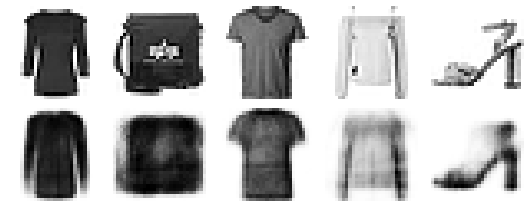

In [12]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

# Visualizing Fashion MNIST

In [13]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

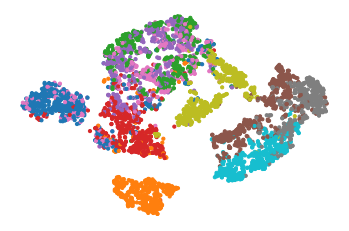

In [14]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Let's make this diagram a bit prettier:

Saving figure fashion_mnist_visualization_plot


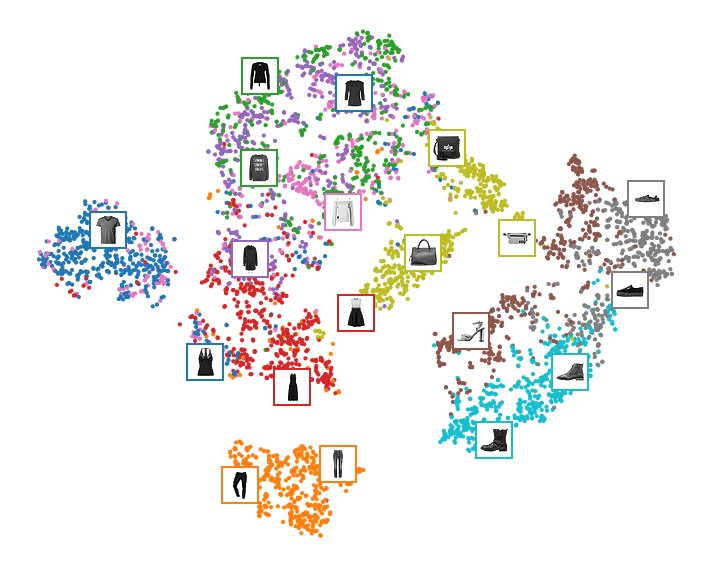

In [15]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

## Tying weights

It is common to tie the weights of the encoder and the decoder, by simply using the transpose of the encoder's
weights as the decoder weights. For this, we need to use a custom layer.

In [16]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)

    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1.5),
                metrics=[rounded_accuracy])

history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
y_true:  Tensor("IteratorGetNext:1", shape=(None, 28, 28), dtype=float32)
Tensor("sequential_2/sequential_1/reshape/Reshape:0", shape=(None, 28, 28), dtype=float32)
y_true:  Tensor("IteratorGetNext:1", shape=(None, 28, 28), dtype=float32)
Tensor("sequential_2/sequential_1/reshape/Reshape:0", shape=(None, 28, 28), dtype=float32)
1698/1719 [============================>.] - ETA: 0s - loss: 0.3272 - rounded_accuracy: 0.8958

In [18]:
tied_encoder.summary()
tied_decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3030      
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_transpose (DenseTransp (None, 100)               3130      
_________________________________________________________________
dense_transpose_1 (DenseTran (None, 784)               79284     
______________________________

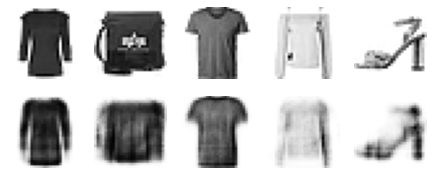

In [19]:
show_reconstructions(tied_ae)
plt.show()

## Training one Autoencoder at a Time

In [20]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]

    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])

    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])

    autoencoder = keras.models.Sequential([encoder, decoder])

    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))

    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [21]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)

enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(lr=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])

enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1,
    "mse", keras.optimizers.SGD(lr=0.05),
    output_activation="selu")

Epoch 1/10
y_true:  Tensor("IteratorGetNext:1", shape=(None, 784), dtype=float32)
Tensor("sequential_5/sequential_4/dense_3/Sigmoid:0", shape=(None, 784), dtype=float32)
y_true:  Tensor("IteratorGetNext:1", shape=(None, 784), dtype=float32)
Tensor("sequential_5/sequential_4/dense_3/Sigmoid:0", shape=(None, 784), dtype=float32)
1712/1719 [============================>.] - ETA: 0s - loss: 0.3446 - rounded_accuracy: 0.8873

In [22]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

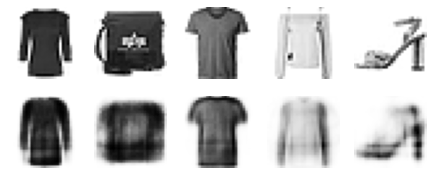

In [23]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [24]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(lr=0.1),
                          metrics=[rounded_accuracy])

history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Epoch 1/10
y_true:  Tensor("IteratorGetNext:1", shape=(None, 28, 28), dtype=float32)
Tensor("sequential_9/reshape_1/Reshape:0", shape=(None, 28, 28), dtype=float32)
y_true:  Tensor("IteratorGetNext:1", shape=(None, 28, 28), dtype=float32)
Tensor("sequential_9/reshape_1/Reshape:0", shape=(None, 28, 28), dtype=float32)
1708/1719 [============================>.] - ETA: 0s - loss: 0.2867 - rounded_accuracy: 0.9343

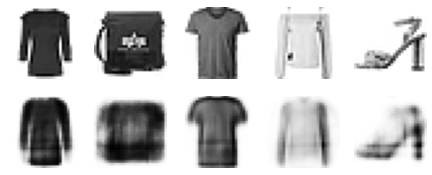

In [25]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

## Using Convolutional Layers Instead of Dense Layers

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [26]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])

history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid),
                      batch_size=512)

Epoch 1/5
y_true:  Tensor("IteratorGetNext:1", shape=(None, 28, 28), dtype=float32)
Tensor("sequential_12/sequential_11/reshape_3/Reshape:0", shape=(None, 28, 28), dtype=float32)
y_true:  Tensor("IteratorGetNext:1", shape=(None, 28, 28), dtype=float32)
Tensor("sequential_12/sequential_11/reshape_3/Reshape:0", shape=(None, 28, 28), dtype=float32)
108/108 [==============================] - ETA: 0s - loss: 0.4316 - rounded_accuracy: 0.8171

In [27]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)        

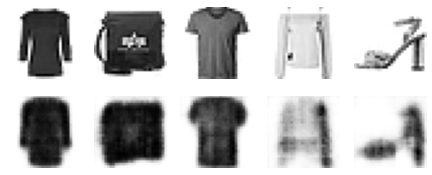

In [28]:
show_reconstructions(conv_ae)
plt.show()

# Recurrent Autoencoders

https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352

In [29]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])

recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])

recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [30]:
recurrent_encoder.summary()
recurrent_decoder.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 28, 100)           51600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                15720     
Total params: 67,320
Trainable params: 67,320
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
repeat_vector (RepeatVector) (None, 28, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 28, 100)           52400     
_________________________________________________________________
time_distributed (TimeDistri (None, 28, 28)            2828      
Total params: 55,228
Train

In [31]:
history = recurrent_ae.fit(X_train, X_train,
                           epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
y_true:  Tensor("IteratorGetNext:1", shape=(None, 28, 28), dtype=float32)
Tensor("sequential_15/sequential_14/time_distributed/Reshape_1:0", shape=(None, 28, 28), dtype=float32)
y_true:  Tensor("IteratorGetNext:1", shape=(None, 28, 28), dtype=float32)
Tensor("sequential_15/sequential_14/time_distributed/Reshape_1:0", shape=(None, 28, 28), dtype=float32)
1709/1719 [============================>.] - ETA: 0s - loss: 0.5195 - rounded_accuracy: 0.7489

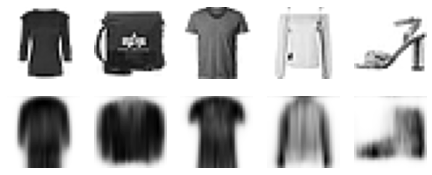

In [32]:
show_reconstructions(recurrent_ae)
plt.show()

# Stacked denoising Autoencoder

Using Gaussian noise:

In [33]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])

denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])

denoising_ae.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])

history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
y_true:  Tensor("IteratorGetNext:1", shape=(None, 28, 28), dtype=float32)
Tensor("sequential_18/sequential_17/reshape_4/Reshape:0", shape=(None, 28, 28), dtype=float32)
y_true:  Tensor("IteratorGetNext:1", shape=(None, 28, 28), dtype=float32)
Tensor("sequential_18/sequential_17/reshape_4/Reshape:0", shape=(None, 28, 28), dtype=float32)
1684/1719 [============================>.] - ETA: 0s - loss: 0.3506 - rounded_accuracy: 0.8768

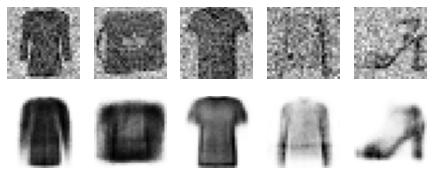

In [34]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

Using dropout:

In [35]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
y_true:  Tensor("IteratorGetNext:1", shape=(None, 28, 28), dtype=float32)
Tensor("sequential_21/sequential_20/reshape_5/Reshape:0", shape=(None, 28, 28), dtype=float32)
y_true:  Tensor("IteratorGetNext:1", shape=(None, 28, 28), dtype=float32)
Tensor("sequential_21/sequential_20/reshape_5/Reshape:0", shape=(None, 28, 28), dtype=float32)
1708/1719 [============================>.] - ETA: 0s - loss: 0.3570 - rounded_accuracy: 0.8708

Saving figure dropout_denoising_plot


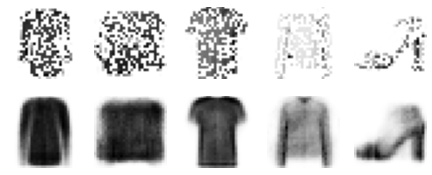

In [36]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot", tight_layout=False)

# Sparse Autoencoder

Let's build a simple stacked autoencoder, so we can compare it to the sparse autoencoders we will build. This time
we will use the sigmoid activation function for the coding layer, to ensure that the coding values range from 0 to 1:

In [37]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

Epoch 1/10
y_true:  Tensor("IteratorGetNext:1", shape=(None, 28, 28), dtype=float32)
Tensor("sequential_24/sequential_23/reshape_6/Reshape:0", shape=(None, 28, 28), dtype=float32)
y_true:  Tensor("IteratorGetNext:1", shape=(None, 28, 28), dtype=float32)
Tensor("sequential_24/sequential_23/reshape_6/Reshape:0", shape=(None, 28, 28), dtype=float32)
1697/1719 [============================>.] - ETA: 0s - loss: 0.4337 - rounded_accuracy: 0.7942

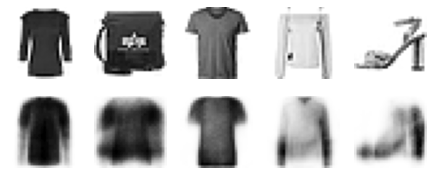

In [38]:
show_reconstructions(simple_ae)
plt.show()

Let's create a couple functions to print nice activation histograms:

In [39]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [40]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

Let's use these functions to plot histograms of the activations of the encoding layer. The histogram on the 
left shows the distribution of all the activations. You can see that values close to 0 or 1 are more 
frequent overall, which is consistent with the saturating nature of the sigmoid function. The histogram on 
the right shows the distribution of mean neuron activations: you can see that most neurons have a mean 
activation close to 0.5. Both histograms tell us that each neuron tends to either fire close to 0 or 1, with 
about 50% probability each. However, some neurons fire almost all the time (right side of the right histogram).

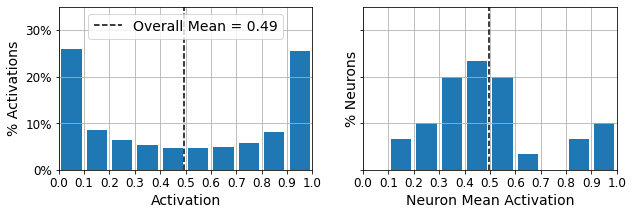

In [41]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

Now let's add $\ell_1$ regularization to the coding layer:

In [42]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
y_true:  Tensor("IteratorGetNext:1", shape=(None, 28, 28), dtype=float32)
Tensor("sequential_27/sequential_26/reshape_7/Reshape:0", shape=(None, 28, 28), dtype=float32)
y_true:  Tensor("IteratorGetNext:1", shape=(None, 28, 28), dtype=float32)
Tensor("sequential_27/sequential_26/reshape_7/Reshape:0", shape=(None, 28, 28), dtype=float32)
1684/1719 [============================>.] - ETA: 0s - loss: 0.4321 - rounded_accuracy: 0.8119

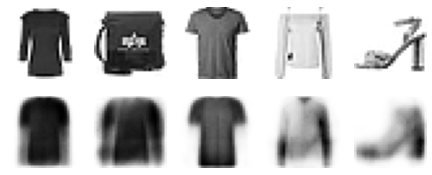

In [43]:
show_reconstructions(sparse_l1_ae)

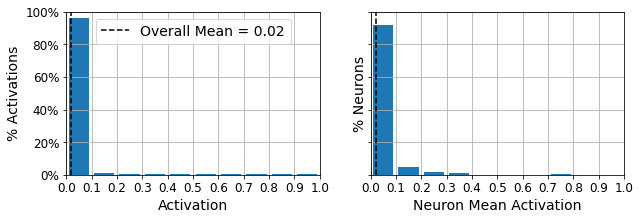

In [44]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

Let's use the KL Divergence loss instead to ensure sparsity, and target 10% sparsity rather than 0%:

Saving figure sparsity_loss_plot


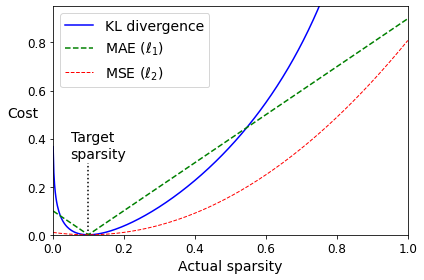

In [45]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("sparsity_loss_plot")

In [46]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [47]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
y_true:  Tensor("IteratorGetNext:1", shape=(None, 28, 28), dtype=float32)
Tensor("sequential_30/sequential_29/reshape_8/Reshape:0", shape=(None, 28, 28), dtype=float32)
y_true:  Tensor("IteratorGetNext:1", shape=(None, 28, 28), dtype=float32)
Tensor("sequential_30/sequential_29/reshape_8/Reshape:0", shape=(None, 28, 28), dtype=float32)
1719/1719 [==============================] - ETA: 0s - loss: 0.4150 - rounded_accuracy: 0.8121

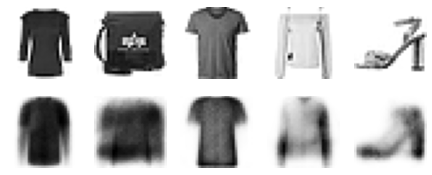

In [48]:
show_reconstructions(sparse_kl_ae)

Saving figure sparse_autoencoder_plot


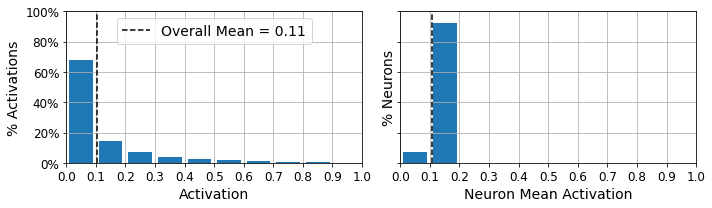

In [49]:
plot_activations_histogram(sparse_kl_encoder)
save_fig("sparse_autoencoder_plot")
plt.show()

# Variational Autoencoder

In [50]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [51]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

# Encoder: Start
inputs = keras.layers.Input(shape=[28, 28])

z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)

codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])
# Encoder: End

# Decoder: Start
decoder_inputs = keras.layers.Input(shape=[codings_size])

x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)

outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])
# Decoder: End


_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)

variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)

variational_ae.add_loss(K.mean(latent_loss) / 784.)

variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])

history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
y_true:  Tensor("IteratorGetNext:1", shape=(None, 28, 28), dtype=float32)
Tensor("functional_5/functional_3/reshape_9/Reshape:0", shape=(None, 28, 28), dtype=float32)
y_true:  Tensor("IteratorGetNext:1", shape=(None, 28, 28), dtype=float32)
Tensor("functional_5/functional_3/reshape_9/Reshape:0", shape=(None, 28, 28), dtype=float32)
412/430 [===========================>..] - ETA: 0s - loss: 0.3908 - rounded_accuracy: 0.8598

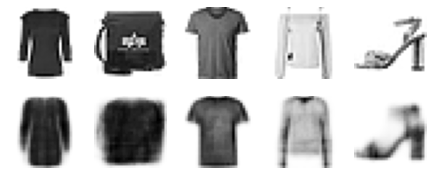

In [52]:
show_reconstructions(variational_ae)
plt.show()

## Generate Fashion Images

In [53]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Let's generate a few random codings, decode them and plot the resulting images:

Saving figure vae_generated_images_plot


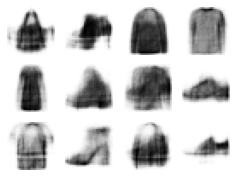

In [54]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

Now let's perform semantic interpolation between these images:

Saving figure semantic_interpolation_plot


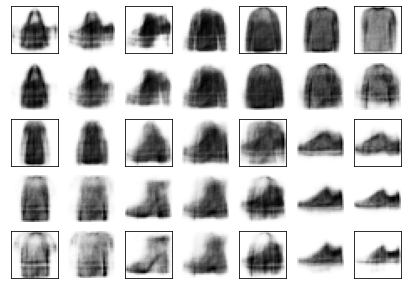

In [55]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("semantic_interpolation_plot", tight_layout=False)


# Exercise Solutions

## Unsupervised pretraining

Let's create a small neural network for MNIST classification:

In [56]:
tf.random.set_seed(42)
np.random.seed(42)

X_train_small = X_train[:500]
y_train_small = y_train[:500]

classifier = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation="selu"),
    keras.layers.Dense(10, activation="softmax")
])
classifier.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(lr=0.02),
                   metrics=["accuracy"])
history = classifier.fit(X_train_small, y_train_small, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
16/16 [==============================] - 0s 19ms/step - loss: 2.1819 - accuracy: 0.2700 - val_loss: 1.9780 - val_accuracy: 0.4162
Epoch 2/20
16/16 [==============================] - 0s 23ms/step - loss: 1.7828 - accuracy: 0.5300 - val_loss: 1.6237 - val_accuracy: 0.5370
Epoch 3/20
16/16 [==============================] - 0s 29ms/step - loss: 1.4091 - accuracy: 0.5940 - val_loss: 1.2613 - val_accuracy: 0.6016
Epoch 4/20
16/16 [==============================] - 0s 16ms/step - loss: 1.0869 - accuracy: 0.6860 - val_loss: 1.0041 - val_accuracy: 0.6888
Epoch 5/20
16/16 [==============================] - 0s 12ms/step - loss: 0.9624 - accuracy: 0.6780 - val_loss: 0.9233 - val_accuracy: 0.6942
Epoch 6/20
16/16 [====================

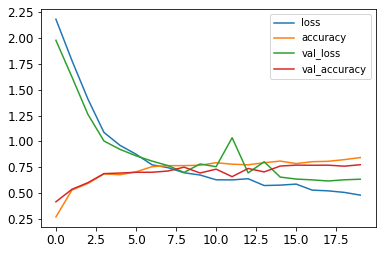

In [57]:
import pandas as pd
pd.DataFrame(history.history).plot()
plt.show()

In [58]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder_clone = keras.models.clone_model(conv_encoder)

pretrained_clf = keras.models.Sequential([
    conv_encoder_clone,
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation="selu"),
    keras.layers.Dense(10, activation="softmax")
])

In [59]:
%%time

conv_encoder_clone.trainable = False
pretrained_clf.compile(loss="sparse_categorical_crossentropy",
                       optimizer=keras.optimizers.SGD(lr=0.02),
                       metrics=["accuracy"])
history = pretrained_clf.fit(X_train_small, y_train_small, epochs=30,
                             validation_data=(X_valid, y_valid))

Epoch 1/30
16/16 [==============================] - 0s 17ms/step - loss: 2.3133 - accuracy: 0.1680 - val_loss: 2.2306 - val_accuracy: 0.2382
Epoch 2/30
16/16 [==============================] - 0s 10ms/step - loss: 2.1850 - accuracy: 0.2760 - val_loss: 2.1302 - val_accuracy: 0.3560
Epoch 3/30
16/16 [==============================] - 0s 11ms/step - loss: 2.0876 - accuracy: 0.4000 - val_loss: 2.0362 - val_accuracy: 0.4132
Epoch 4/30
16/16 [==============================] - 0s 10ms/step - loss: 1.9943 - accuracy: 0.4720 - val_loss: 1.9561 - val_accuracy: 0.5152
Epoch 5/30
16/16 [==============================] - 0s 11ms/step - loss: 1.9140 - accuracy: 0.5520 - val_loss: 1.8746 - val_accuracy: 0.5920
Epoch 6/30
16/16 [==============================] - 0s 10ms/step - loss: 1.8325 - accuracy: 0.6400 - val_loss: 1.7987 - 

In [60]:
%%time

conv_encoder_clone.trainable = True
pretrained_clf.compile(loss="sparse_categorical_crossentropy",
                       optimizer=keras.optimizers.SGD(lr=0.02),
                       metrics=["accuracy"])

history = pretrained_clf.fit(X_train_small, y_train_small, epochs=20,
                             validation_data=(X_valid, y_valid))

Epoch 1/20
16/16 [==============================] - 0s 16ms/step - loss: 0.8375 - accuracy: 0.7440 - val_loss: 0.7992 - val_accuracy: 0.7188
Epoch 2/20
16/16 [==============================] - 0s 10ms/step - loss: 0.7373 - accuracy: 0.7620 - val_loss: 0.7914 - val_accuracy: 0.7200
Epoch 3/20
16/16 [==============================] - 0s 11ms/step - loss: 0.7170 - accuracy: 0.7660 - val_loss: 0.7820 - val_accuracy: 0.7048
Epoch 4/20
16/16 [==============================] - 0s 11ms/step - loss: 0.6699 - accuracy: 0.7800 - val_loss: 0.7182 - val_accuracy: 0.7310
Epoch 5/20
16/16 [==============================] - 0s 11ms/step - loss: 0.6544 - accuracy: 0.7600 - val_loss: 0.6875 - val_accuracy: 0.7442
Epoch 6/20
16/16 [==============================] - 1s 32ms/step - loss: 0.6411 - accuracy: 0.7760 - val_loss: 0.7085 - 

## Hashing Using a Binary Autoencoder

In [61]:
tf.random.set_seed(42)
np.random.seed(42)

hashing_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.GaussianNoise(15.),
    keras.layers.Dense(16, activation="sigmoid"),
])
hashing_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[16]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
hashing_ae = keras.models.Sequential([hashing_encoder, hashing_decoder])
hashing_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])
history = hashing_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
y_true:  Tensor("IteratorGetNext:1", shape=(None, 28, 28), dtype=float32)
Tensor("sequential_35/sequential_34/reshape_11/Reshape:0", shape=(None, 28, 28), dtype=float32)
y_true:  Tensor("IteratorGetNext:1", shape=(None, 28, 28), dtype=float32)
Tensor("sequential_35/sequential_34/reshape_11/Reshape:0", shape=(None, 28, 28), dtype=float32)
1713/1719 [============================>.] - ETA: 0s - loss: 0.4999 - rounded_accuracy: 0.7265

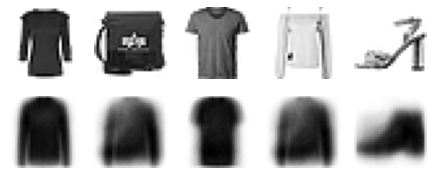

In [62]:
show_reconstructions(hashing_ae)
plt.show()

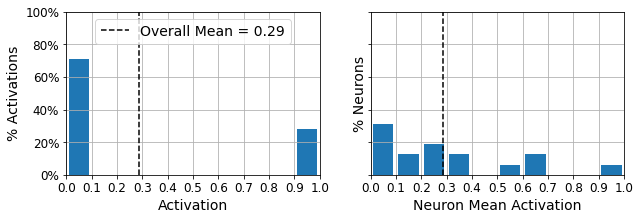

In [63]:
plot_activations_histogram(hashing_encoder)
plt.show()

In [64]:
hashes = np.round(hashing_encoder.predict(X_valid)).astype(np.int32)
hashes *= np.array([[2**bit for bit in range(16)]])
hashes = hashes.sum(axis=1)
for h in hashes[:5]:
    print("{:016b}".format(h))
print("...")

0000100000011001
0000100000000001
0100100000011001
0000100000000001
0000100001000000
...


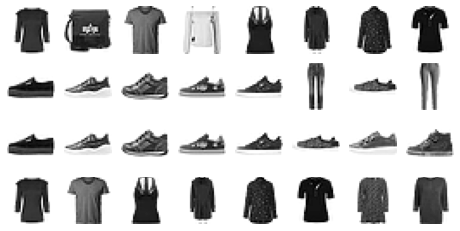

In [65]:
n_bits = 4
n_images = 8
plt.figure(figsize=(n_images, n_bits))
for bit_index in range(n_bits):
    in_bucket = (hashes & 2**bit_index != 0)
    for index, image in zip(range(n_images), X_valid[in_bucket]):
        plt.subplot(n_bits, n_images, bit_index * n_images + index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")